In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timedelta
import utils
import config
import inspect
import folium
from dateutil import relativedelta

def class_to_df(cfg_class):
    class_name = cfg_class.__name__
    attributes = [attr for attr in dir(cfg_class) if not callable(getattr(cfg_class, attr)) and not attr.startswith("__")]
    data = {attr: [getattr(cfg_class, attr)] for attr in attributes}
    data['class_name'] = [class_name]
    return pd.DataFrame(data)

In [3]:
class CFG:
    make_folder = True
    note_num = "StackingOpt/result2001"
    seed = 42


OUTPUT_DIR = f'E:/study/output/{CFG.note_num}/'

if CFG.make_folder:
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)


# データセットについて

In [4]:
id_all_data = pd.read_csv("E:\study\output\StackingOpt\EDA006\id_all_data.csv")
df,unique_id = utils.load_data2()

In [5]:
cols = ['datetime', #　日付
        'flag',  #
        'two_weeks_max', #2週間最大値
        'id', # PVのid
        'generation', #　発電量
        
        # 時間
        'year',
        'month', 
        'day', 
        'hour', 
        'minute', 

        #時間の周期性を表現するために三角関数に変換
        'month_angle', 
        'day_angle',
        'hour_angle', 
        'month_sin', 
        'month_cos', 
        'day_sin', 
        'day_cos',
        'hour_sin', 
        'hour_cos', 
        'year_seconds', 
        'year_angle', 
        'year_sin',
        'year_cos', 


        'prev_30m_generation', #30分前の発電量
        'id_lat', #　緯度
        'id_lng', #　経度
        'id_lat_mesh', # メッシュ化した緯度
        'id_lng_mesh', # メッシュ化した経度
        'id_prefecture', #　都道府県
        'pvrate', #　定格
        'observed_max', # 期間内最大値(id_all_dataより)
        'observed_max2', # 期間内最大値(再計算)
        'nv', # 規格化値
        'nv2' # 規格化値(generation/observed_max2)
        ]

In [7]:
df[cols].head(5)

,datetime,flag,two_weeks_max,id,generation,year,month,day,hour,minute,month_angle,day_angle,hour_angle,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,year_seconds,year_angle,year_sin,year_cos,prev_30m_generation,id_lat,id_lng,id_lat_mesh,id_lng_mesh,id_prefecture,pvrate,observed_max,observed_max2,nv,nv2
0,2013-08-15 07:00:00,2.0,2626.0,564.0,2011.5160,2013.0,8.0,15.0,7.0,0.0,3.665191,2.932153,1.832596,-0.5,-0.866025,0.207912,-0.978148,0.965926,-0.258819,1.376550e+09,274.074034,-0.685633,-0.727947,1258.5920,36.67271,137.26581,36.68,137.26,富山県,7.4,5150.5454,5165.6,0.766,0.389406
1,2013-08-15 07:30:00,2.0,3001.0,564.0,2706.9020,2013.0,8.0,15.0,7.0,30.0,3.665191,2.932153,1.832596,-0.5,-0.866025,0.207912,-0.978148,0.965926,-0.258819,1.376552e+09,274.074392,-0.685894,-0.727701,2011.5160,36.67271,137.26581,36.68,137.26,富山県,7.4,5150.5454,5165.6,0.902,0.524025
2,2013-08-15 08:00:00,2.0,3616.6,564.0,3273.0230,2013.0,8.0,15.0,8.0,0.0,3.665191,2.932153,2.094395,-0.5,-0.866025,0.207912,-0.978148,0.866025,-0.500000,1.376554e+09,274.074751,-0.686155,-0.727456,2706.9020,36.67271,137.26581,36.68,137.26,富山県,7.4,5150.5454,5165.6,0.905,0.633619
3,2013-08-15 08:30:00,2.0,4260.6,564.0,3676.8978,2013.0,8.0,15.0,8.0,30.0,3.665191,2.932153,2.094395,-0.5,-0.866025,0.207912,-0.978148,0.866025,-0.500000,1.376555e+09,274.075109,-0.686415,-0.727210,3273.0230,36.67271,137.26581,36.68,137.26,富山県,7.4,5150.5454,5165.6,0.863,0.711805
4,2013-08-15 09:00:00,2.0,4079.6,564.0,4030.6448,2013.0,8.0,15.0,9.0,0.0,3.665191,2.932153,2.356194,-0.5,-0.866025,0.207912,-0.978148,0.707107,-0.707107,1.376557e+09,274.075468,-0.686676,-0.726964,3676.8978,36.67271,137.26581,36.68,137.26,富山県,7.4,5150.5454,5165.6,0.988,0.780286


In [13]:
id_all_data

,id,id_lat,id_lng,id_lat_mesh,id_lng_mesh,id_prefecture,pvrate,observed_max,observed_max2
0,6,35.81228,139.72822,35.82,139.72,埼玉県,3.42,3014.2112,NaN
1,9,31.92295,131.44116,31.92,131.44,宮崎県,3.00,NaN,NaN
2,12,35.67967,139.82913,35.68,139.82,東京都,6.02,4502.4124,NaN
3,14,35.09792,136.88363,35.10,136.88,愛知県,4.13,3556.2000,NaN
4,17,35.50329,139.69705,35.50,139.70,神奈川県,2.79,2032.7072,NaN
...,...,...,...,...,...,...,...,...,...
5092,6990000048,36.12519,140.51805,36.12,140.52,茨城県,16.50,14596.1192,14773.4
5093,6990000049,36.12519,140.51805,36.12,140.52,茨城県,14.83,13139.6332,13326.2
5094,6990000050,36.19365,140.34600,36.20,140.34,茨城県,16.24,13545.8344,13627.6
5095,6990000051,36.19365,140.34600,36.20,140.34,茨城県,14.25,12180.4000,12250.8


# オプティカルフローの予測精度

In [112]:
id_all_data = pd.read_csv("E:\study\output\StackingOpt\EDA006\id_all_data.csv")

In [114]:
unique_id = [6240000001, 1670000003, 6310000002, 6310000001, 6900000114, 6900000110, 6900000109, 6900000108, 6900000105, 6900000104, 6900000094, 6900000093, 6900000090, 2100000086, 2100000085, 2100000084, 6900000081, 6900000080, 2100000068, 2100000067, 2100000066, 6910000449, 6910000448, 6900000131, 6950000001, 6900000173, 6900000134, 6900000171, 6900000168, 6900000166, 6900000165, 6900000162, 6900000161, 6900000158, 6910000541, 6900000156, 6900000155, 6900000154, 6900000153, 6900000152, 6900000150, 6900000149, 6900000145, 6900000144, 6900000143, 6900000142, 6630000003, 6630000002, 6910000438, 6900000054, 6900000049, 6900000047, 6910000327, 6910000308, 6910000306, 6910000303, 6910000301, 6910000299, 6910000298, 6910000294, 6910000293, 6910000292, 6910000291, 6910000287, 6910000283, 6910000282, 6910000281, 6910000279, 6910000276, 1730000020, 6910000274, 6910000272, 6910000271, 6910000343, 2420000001, 6900000002, 2070000002, 6900000045, 6900000044, 6900000041, 6900000040, 6900000035, 6900000034, 6900000029, 6900000028, 6900000025, 6900000021, 6900000003, 6900000020, 6900000019, 6900000014, 6900000013, 6900000012, 6900000011, 6900000010, 6100000001, 2900000002, 6900000172, 6900000199, 1730000007, 6620000076, 6620000062, 6620000056, 6620000055, 6620000045, 6620000022, 1660000013, 1660000012, 1660000017, 1660000016, 6780000011, 2460000014, 1660000006, 2460000012, 2460000011, 1660000005, 2460000009, 2460000008, 2460000007, 2460000006, 2460000005, 2460000002, 6620000063, 6620000079, 6900000200, 6620000082, 6620000152, 6620000151, 6620000145, 2030000007, 2190000001, 1710000005, 2350000002, 2190000003, 2030000004, 6030000003, 2190000002, 2350000001, 6620000101, 6620000098, 6620000097, 6620000096, 6620000095, 6620000093, 6620000092, 6620000091, 6620000085, 2460000001, 3000000211, 6090000064, 3000000184, 6840000007, 6840000006, 6840000005, 6840000004, 1400000005, 1240000005, 1400000004, 1240000003, 6900000250, 6900000244, 6900000242, 6900000240, 6900000238, 6900000223, 6900000221, 6900000220, 6900000215, 6900000214, 6900000210, 6900000205, 6900000202, 6900000268, 6900000269, 6900000275, 3000000137, 1750000008, 3000000173, 3000000172, 1770000018, 1770000016, 10000014, 3000000141, 3000000139, 1290000008, 1610000008, 6900000279, 1610000002, 6570000002, 1930000001, 3000000127, 6040000097, 6040000078, 6040000077, 6040000068, 6900000298, 6240000006, 6910000265, 6910000262, 1010000297, 5000000129, 5000000128, 1160000113, 5000000105, 1160000101, 1160000059, 564, 1160000040, 1160000033, 5000000023, 1160000020, 2440000014, 2760000005, 5000000001, 6760000001, 2110000003, 6070000097, 1010000353, 6070000096, 6070000074, 1010000324, 5000000130, 6010000002, 6010000003, 1690000042, 1160000200, 1690000069, 1690000066, 1210000067, 1210000066, 1210000065, 1160000190, 1160000188, 1690000054, 1690000041, 1210000005, 1690000033, 1690000030, 1160000156, 1690000027, 1210000018, 6650000011, 1210000010, 1210000009, 1210000006, 1010000298, 6070000038, 1160000227, 1270000038, 6180000002, 6180000001, 2340000001, 1010000110, 1010000105, 1010000098, 1010000088, 1010000058, 1010000048, 1010000032, 1010000029, 6130000007, 1810000005, 2450000003, 2450000002, 2130000001, 1010000002, 2130000002, 2450000001, 2720000013, 2720000011, 6180000003, 1010000137, 6500000013, 6550000001, 1750000010, 1270000016, 1270000015, 1270000014, 2390000005, 2390000004, 2390000003, 2390000002, 6550000002, 2230000003, 6500000014, 2230000002, 2230000001, 6710000004, 6710000002, 2070000003, 6710000001, 2070000001, 6340000019, 6500000015, 1690000098, 6620000159, 2540000001, 6910000132, 1840000001, 6910000129, 6910000128, 6910000127, 6910000121, 6910000120, 6910000119, 6910000116, 6910000080, 6910000076, 6910000069, 6910000067, 6910000065, 6910000063, 6910000060, 6910000056, 6910000054, 6910000051, 6910000047, 6910000044, 6910000041, 1840000003, 1840000002, 6910000021, 6910000134, 6910000260, 1570000001, 6910000256, 6910000255, 6910000169, 6910000167, 6910000161, 6910000160, 6910000159, 6910000158, 6910000155, 6910000154, 6910000153, 6910000152, 6910000150, 6910000148, 6910000145, 6910000144, 6910000140, 6910000137, 6910000135, 6910000038, 6910000029, 1160000299, 6700000001, 1160000321, 6910000020, 1690000168, 1690000167, 1690000164, 1160000291, 1690000158, 1690000156, 1160000284, 1740000001, 1690000155, 1160000272, 1690000143, 1690000142, 1690000140, 1580000005, 1690000129, 1580000004, 1580000003, 1690000206, 2010000132, 1690000209, 6910000002, 6910000018, 1900000002, 2390000001, 6910000017, 6910000016, 2110000004, 6910000004, 6910000003, 6910000001, 2430000001, 6860000001, 6590000002, 6590000001, 2430000006, 2430000005, 2430000004, 2430000003, 2430000002, 6700000002]
to_unique_id = [str(num).zfill(10) for num in unique_id]



In [216]:
data = id_all_data[id_all_data.id.isin(unique_id)]
# 地図の中心座標を設定 (ここでは最初の緯度・経度)
map_center = data.iloc[0][['id_lat', 'id_lng']].tolist()

# 地図を生成
m = folium.Map(location=map_center, zoom_start=7)

# 各地点にマーカーを追加
for _, row in data.iterrows():
    folium.Marker([row['id_lat'], row['id_lng']]).add_to(m)

m

# 実験1~6のまとめ

In [108]:
df3_opt = pd.read_csv(OUTPUT_DIR+"df3_opt.csv")

combined_df = pd.read_csv(OUTPUT_DIR+"combined_df_all.csv")

combined_df = utils.get_result1(combined_df)
combined_df = combined_df[["class_name","load_data_kind","use_flo_unique_features","oof_mae","test_mae","duration_months","test_month"]].fillna("load_data2")

In [109]:
import pandas as pd

month_list,opt_mape_list,prev_mape_list = [],[],[]
for month in [5, 6, 7]:
    group = df3_opt[df3_opt['month'] == month]
    month_list.append(month)
    opt_mape_list.append(group['APE'].mean())
    prev_mape_list.append(group['APE_prev'].mean())

opt = pd.DataFrame(zip(month_list,opt_mape_list),columns=["test_month","test_mae"])
prev = pd.DataFrame(zip(month_list,prev_mape_list),columns=["test_month","test_mae"])

opt["group"] = "オプティカルフロー"
prev["group"] = "持続予測"

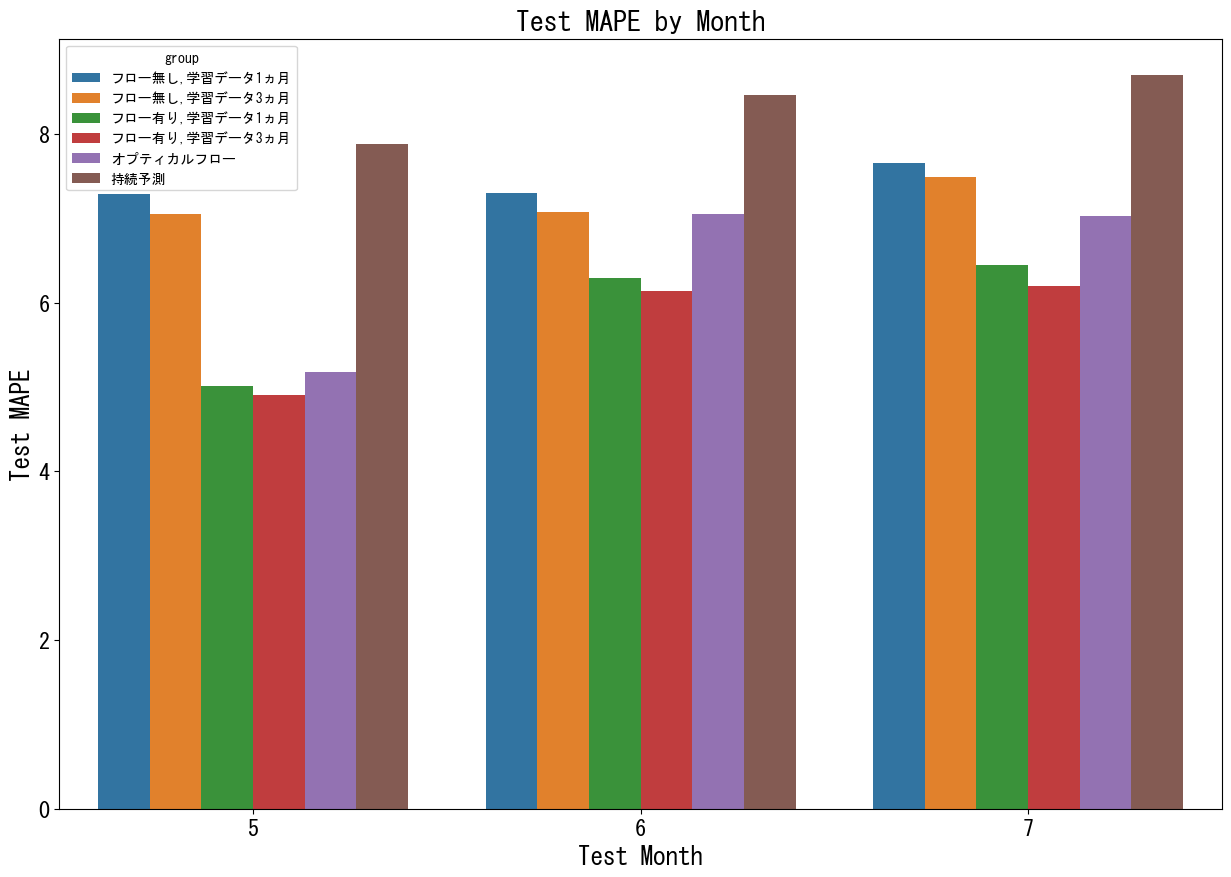

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

group_list = []
for (kind,flo,duration),group in combined_df.groupby(['load_data_kind', 'use_flo_unique_features','duration_months']):
    if duration == 5:
        continue
    else:
        if flo:
            label1 = "有り"
        else:
            label1 = "無し"
        if kind == "load_data1":
            label2 = "4885"
        elif kind == "load_data2":
            label2 = "390"

        group.sort_values(by="test_month",inplace=True)
        # label = f"フロー{label1}({label2}台),学習データ{duration}ヵ月"
        label = f"フロー{label1},学習データ{duration}ヵ月"
        group["group"] = label
        group_list.append(group)

data = pd.concat(group_list)
data = data[data.load_data_kind=="load_data2"]
data["test_mae"] *= 100
data = pd.concat([data,opt])
data = pd.concat([data,prev])

fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(x='test_month', y='test_mae', hue='group', data=data)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.title('Test MAPE by Month',fontsize=20)
plt.ylabel('Test MAPE',fontsize=18)
plt.xlabel('Test Month',fontsize=18)
plt.show()
fig.savefig(r'C:\Users\Yosui\Desktop\hiroki\lab\ゼミ\進捗報告\230525\figure.png')  # 保存先やファイル名は適宜変更してください




In [111]:
for month in [5,6,7]:
    group = data[data.test_month==month]
    dif = group[group.group=="オプティカルフロー"].test_mae.item()- group[(group.use_flo_unique_features==True)&(group.duration_months==3)].test_mae.item()
    print(f"{month}月、{dif}")

5月、0.2717985036916648
6月、0.9082518118930709
7月、0.8352085713313047


In [124]:
df3_opt["APE"]

0           3.201670
1           9.581170
2           3.155493
3           1.514337
4           7.852614
             ...    
3148465    24.686996
3148466     4.621798
3148467     1.530327
3148468     1.487585
3148469     2.704898
Name: APE, Length: 3148470, dtype: float64

# フロー有り、無しLGBM(学習データ3ヵ月),オプティカルフローの比較

In [128]:
combined_df[(combined_df.load_data_kind=="load_data2")&(combined_df.duration_months==3)&(combined_df.use_flo_unique_features==True)]

,class_name,load_data_kind,use_flo_unique_features,oof_mae,test_mae,duration_months,test_month
4,CFG13,load_data2,True,0.045656,0.061362,3,6
14,CFG22,load_data2,True,0.044790,0.049022,3,5
21,CFG4,load_data2,True,0.050516,0.061899,3,7


In [162]:
config_note_name = "config.py"
# 使用するCFGクラス名を指定
usecfg = [f"CFG{i}" for i in [4,13,22] ]

# configモジュール内のCFG接頭辞を持つすべてのクラスを取得し、使用するクラスだけをリストに追加
cfg_list = [cls for name, cls in inspect.getmembers(config, inspect.isclass) if name.startswith("CFG") and name in usecfg]

# すべてのCFGクラスをデータフレームに変換し、リストに追加して結合
combined_df2 = pd.concat([class_to_df(cfg_class) for cfg_class in cfg_list], ignore_index=True)
combined_df2["config_note_name"] = config_note_name 

scores = []
oof_list = []
for _oof_path in combined_df2.note_num:
    oof_path = "E:/study/output/" + _oof_path + "/oof.csv"
    oof = pd.read_csv(oof_path)
    oof_list.append(oof)


oof_flo = pd.concat(oof_list)

oof_flo["datetime"] =pd.to_datetime(oof_flo["datetime"])
oof_flo["month"] = oof_flo["datetime"].dt.month 

oof_flo = oof_flo[oof_flo.fold=="test"]

flo_mape = dict()
for id,group in oof_flo.groupby("id"):
    mape = utils.compute_mae(group["pred"], group["nv2"])*100
    flo_mape[id] = mape

In [164]:
combined_df[(combined_df.load_data_kind=="load_data2")&(combined_df.duration_months==3)&(combined_df.use_flo_unique_features==False)]

,class_name,load_data_kind,use_flo_unique_features,oof_mae,test_mae,duration_months,test_month
5,CFG14,load_data2,False,0.058192,0.070761,3,6
15,CFG23,load_data2,False,0.058727,0.070463,3,5
22,CFG5,load_data2,False,0.062301,0.074867,3,7


In [165]:
config_note_name = "config.py"
# 使用するCFGクラス名を指定
usecfg = [f"CFG{i}" for i in [5,14,23] ]

# configモジュール内のCFG接頭辞を持つすべてのクラスを取得し、使用するクラスだけをリストに追加
cfg_list = [cls for name, cls in inspect.getmembers(config, inspect.isclass) if name.startswith("CFG") and name in usecfg]

# すべてのCFGクラスをデータフレームに変換し、リストに追加して結合
combined_df2 = pd.concat([class_to_df(cfg_class) for cfg_class in cfg_list], ignore_index=True)
combined_df2["config_note_name"] = config_note_name 

scores = []
oof_list = []
for _oof_path in combined_df2.note_num:
    oof_path = "E:/study/output/" + _oof_path + "/oof.csv"
    oof = pd.read_csv(oof_path)
    oof_list.append(oof)


oof_not_flo = pd.concat(oof_list)

oof_not_flo["datetime"] =pd.to_datetime(oof_not_flo["datetime"])
oof_not_flo["month"] = oof_not_flo["datetime"].dt.month 

oof_not_flo = oof_not_flo[oof_not_flo.fold=="test"]

not_flo_mape = dict()
for id,group in oof_not_flo.groupby("id"):
    mape = utils.compute_mae(group["pred"], group["nv2"])*100
    not_flo_mape[id] = mape

In [171]:
df3_opt = pd.read_csv(OUTPUT_DIR+"df3_opt.csv")
df3_opt = df3_opt[df3_opt.month.isin([5,6,7])]

flo = dict()
for id,group in df3_opt.groupby("id"):
    flo[id] = group.APE.mean()

In [188]:
flo = pd.DataFrame(list(flo.items()),columns=["id","mape_flo"])
flo_lgbm = pd.DataFrame(list(flo_mape.items()),columns=["id","mape_flo_lgbm"])
not_flo_lgbm = pd.DataFrame(list(not_flo_mape.items()),columns=["id","mape_not_flo_lgbm"])

In [192]:
mape_all  = flo.merge(flo_lgbm,on="id",how="left")
mape_all = mape_all.merge(not_flo_lgbm,on="id",how="left")

(2.0, 17.0)

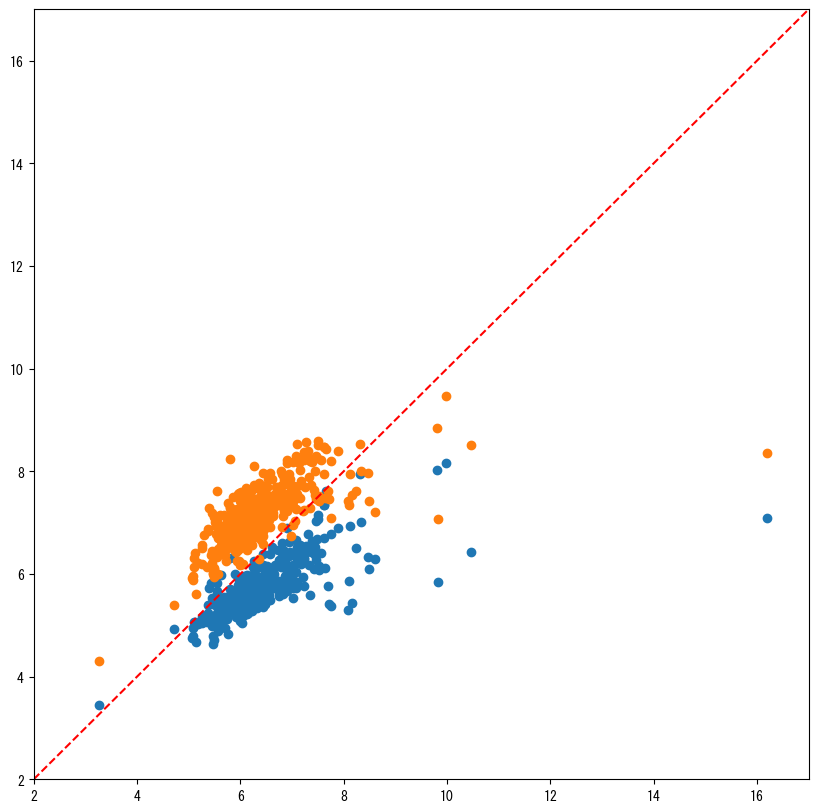

In [201]:
fig = plt.figure(figsize=(10,10))
plt.scatter(mape_all["mape_flo"],mape_all["mape_flo_lgbm"])
plt.scatter(mape_all["mape_flo"],mape_all["mape_not_flo_lgbm"])
plt.plot([2, 17], [2, 17], color='red', linestyle='--')

plt.xlim(2,17)
plt.ylim(2,17)

In [ ]:
mape_all = mape_all.merge(id_all_data[["id","id_lat","id_lng","observed_max2"]],on="id",how="left")

In [204]:
mape_all["mape_flo_lgbm//1"] = mape_all["mape_flo_lgbm"]//1
mape_all["mape_flo//1"] = mape_all["mape_flo"]//1

In [213]:
mape_all.corr()["mape_flo"].sort_values(ascending=False,key=abs)

mape_flo             1.000000
mape_flo_lgbm        0.705994
mape_not_flo_lgbm    0.666871
mape_flo_lgbm//1     0.663639
observed_max2       -0.107948
id_lat               0.048543
id_lng               0.027492
id                  -0.022378
Name: mape_flo, dtype: float64

In [225]:
mape_all[["mape_flo","mape_flo_lgbm"]].describe()

,mape_flo,mape_flo_lgbm
count,390.000000,390.000000
mean,6.407653,5.738470
std,0.921309,0.527715
min,3.272302,3.448429
25%,5.919042,5.414649
50%,6.272015,5.644710
75%,6.760485,5.970592
max,16.191929,8.165847


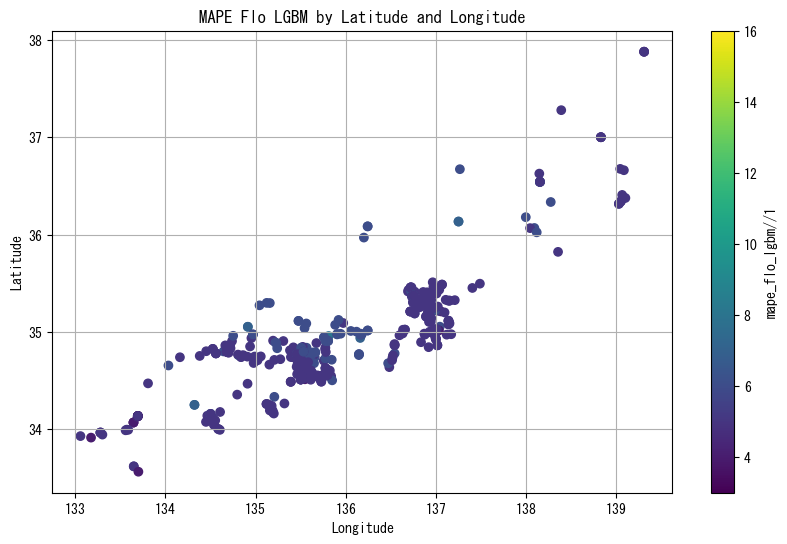

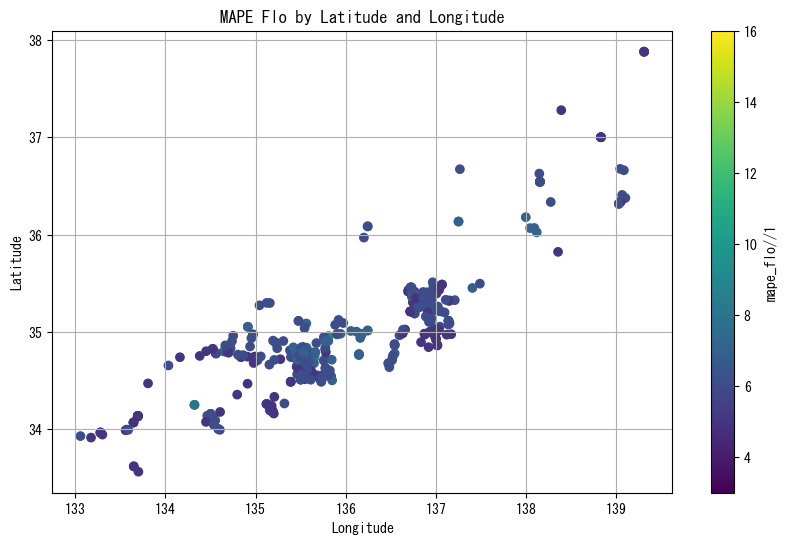

In [226]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = mape_all[["id_lat","id_lng","mape_flo_lgbm//1"]]
df2 = mape_all[["id_lat","id_lng","mape_flo//1"]]

# 全体の最小値と最大値を取得
vmin = min(df1['mape_flo_lgbm//1'].min(), df2['mape_flo//1'].min())
vmax = max(df1['mape_flo_lgbm//1'].max(), df2['mape_flo//1'].max())

# データのプロット
plt.figure(figsize=(10, 6))
plt.scatter(df1['id_lng'], df1['id_lat'], c=df1['mape_flo_lgbm//1'], cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(label='mape_flo_lgbm//1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE Flo LGBM by Latitude and Longitude')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df2['id_lng'], df2['id_lat'], c=df2['mape_flo//1'], cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(label='mape_flo//1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE Flo by Latitude and Longitude')
plt.grid(True)
plt.show()


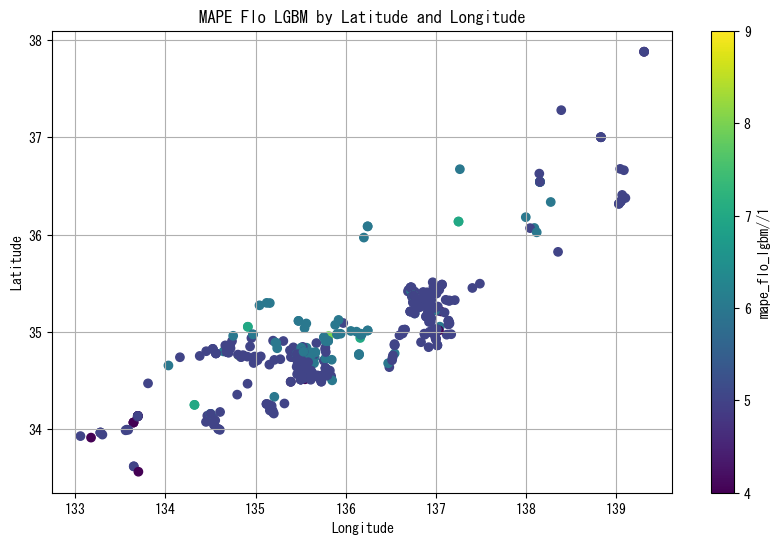

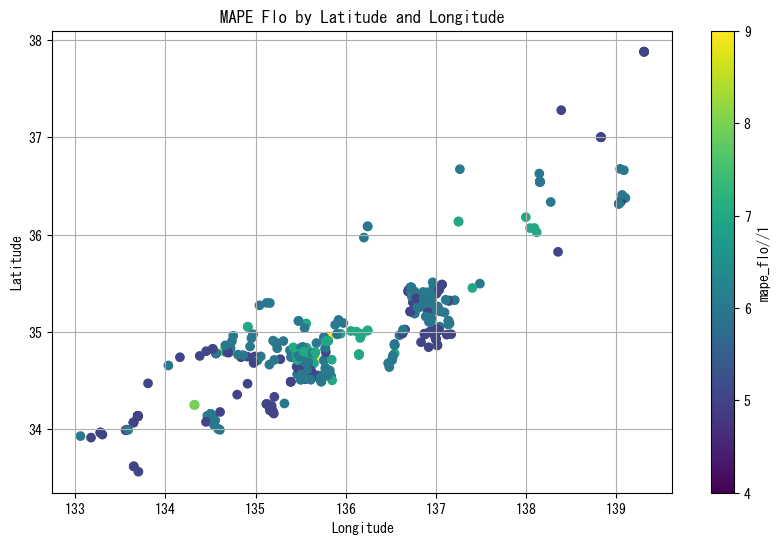

In [256]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = mape_all[["id_lat","id_lng","mape_flo_lgbm//1"]]
df2 = mape_all[["id_lat","id_lng","mape_flo//1"]]

# 全体の最小値と最大値を取得
vmin = 4
vmax = 9

# データのプロット
plt.figure(figsize=(10, 6))
plt.scatter(df1['id_lng'], df1['id_lat'], c=df1['mape_flo_lgbm//1'], cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(label='mape_flo_lgbm//1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE Flo LGBM by Latitude and Longitude')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df2['id_lng'], df2['id_lat'], c=df2['mape_flo//1'], cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(label='mape_flo//1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE Flo by Latitude and Longitude')
plt.grid(True)
plt.show()


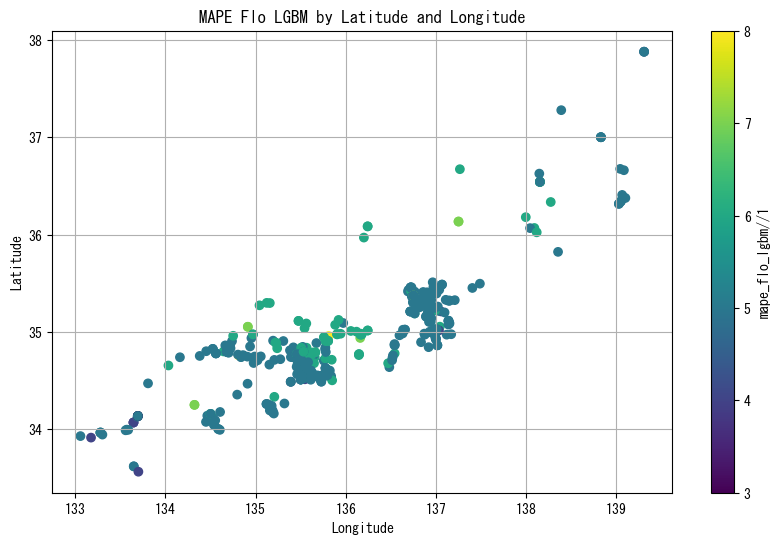

In [227]:
plt.figure(figsize=(10, 6))
plt.scatter(df1['id_lng'], df1['id_lat'], c=df1['mape_flo_lgbm//1'], cmap='viridis')
plt.colorbar(label='mape_flo_lgbm//1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE Flo LGBM by Latitude and Longitude')
plt.grid(True)
plt.show()


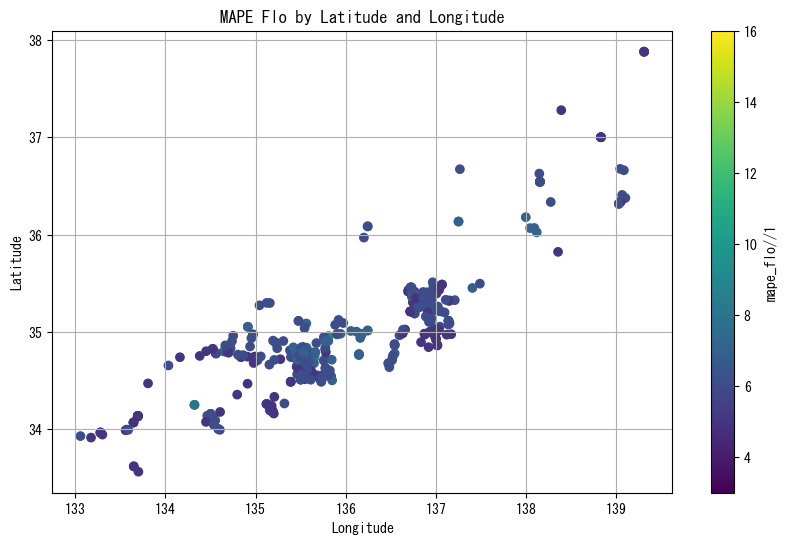

In [238]:
plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df['mape_flo//1'], cmap='viridis')
plt.colorbar(label='mape_flo//1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE Flo by Latitude and Longitude')
plt.grid(True)
plt.show()


In [229]:
mape_all["mape_diff"] = mape_all["mape_flo"] - mape_all["mape_flo_lgbm"]

In [233]:
mape_all.corr()["mape_diff"].sort_values(ascending=False,key=abs)

mape_diff            1.000000
mape_flo             0.826513
mape_flo//1          0.802379
mape_not_flo_lgbm    0.233788
mape_flo_lgbm//1     0.213179
mape_flo_lgbm        0.184844
observed_max2       -0.100287
id_lat              -0.050255
id                  -0.031966
id_lng               0.006209
Name: mape_diff, dtype: float64

In [288]:
mape_all.corr()["mape_flo_lgbm"].sort_values(ascending=False,key=abs)

mape_flo_lgbm        1.000000
mape_flo_lgbm//1     0.890407
mape_not_flo_lgbm    0.870121
mape_flo             0.705994
mape_flo//0.25       0.705660
mape_flo//1          0.654563
mape_diff//1         0.207295
mape_diff//0.25      0.187966
mape_diff            0.184844
mape_diff//0.5       0.181197
id_lat               0.147975
observed_max2       -0.062287
id_lng               0.040185
id                   0.001149
Name: mape_flo_lgbm, dtype: float64

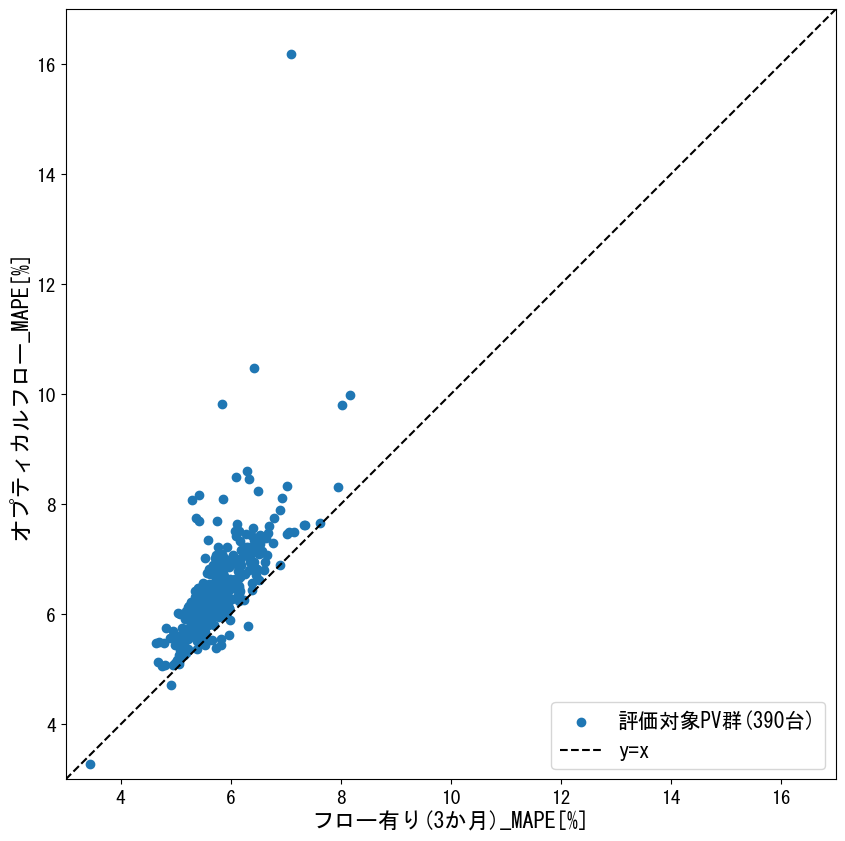

In [287]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mape_all["mape_flo_lgbm"], mape_all["mape_flo"], label="評価対象PV群(390台)")
plt.plot([3, 17], [3, 17], color='black', linestyle='--', label="y=x")
plt.xlim(3, 17)
plt.ylim(3, 17)
plt.xlabel("フロー有り(3か月)_MAPE[%]", fontsize=16)  # xlabelのフォントサイズを指定
plt.ylabel("オプティカルフロー_MAPE[%]", fontsize=16)  # ylabelのフォントサイズを指定
plt.gca().set_aspect('equal')
plt.legend(fontsize=15)  # 凡例のフォントサイズを指定

# メモリのフォントサイズを指定
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()
fig.savefig(r'C:\Users\Yosui\Desktop\hiroki\lab\ゼミ\進捗報告\230525\scatter.png')

In [367]:
((mape_all["mape_flo"]-mape_all["mape_flo_lgbm"])>0).sum()

377

In [292]:
 mape_all[mape_all.mape_flo == mape_all["mape_flo"].max()][["mape_flo","mape_flo_lgbm"]]

,mape_flo,mape_flo_lgbm
334,16.191929,7.091651


In [247]:
mape_all["mape_diff//1"] = mape_all["mape_diff"] //1 
mape_all["mape_diff//0.5"] = mape_all["mape_diff"] //0.5
mape_all["mape_diff//0.25"] = mape_all["mape_diff"] //0.25

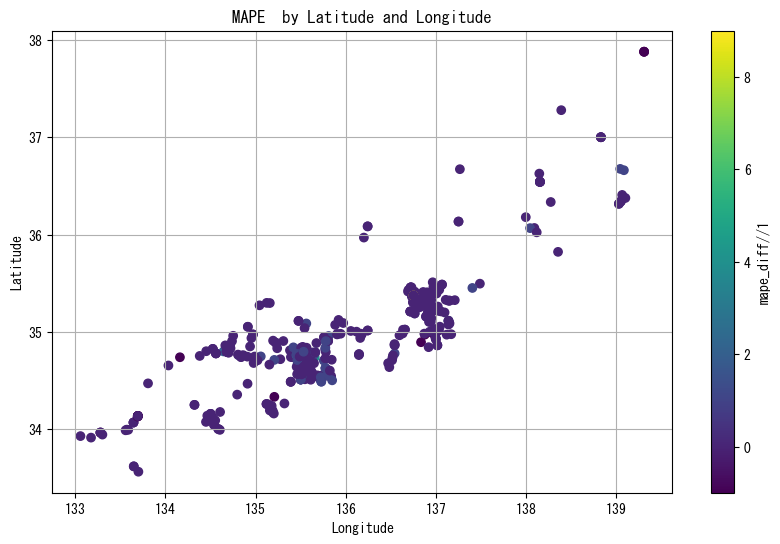

In [236]:
import pandas as pd
import matplotlib.pyplot as plt

col = "mape_diff//1"
df = mape_all

# データのプロット
plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df[col], cmap='viridis')
plt.colorbar(label=col)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE  by Latitude and Longitude')
plt.grid(True)
plt.show()


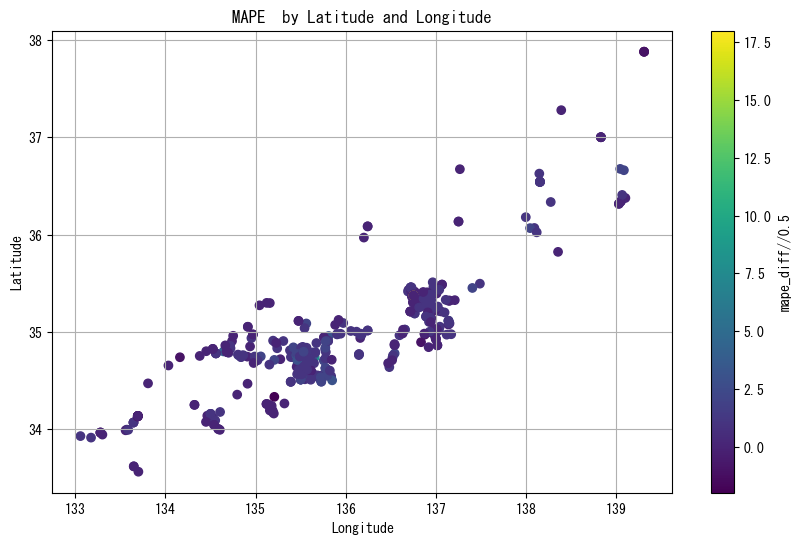

In [243]:
import pandas as pd
import matplotlib.pyplot as plt

col = "mape_diff//0.5"
df = mape_all

# データのプロット
plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df[col], cmap='viridis')
plt.colorbar(label=col)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE  by Latitude and Longitude')
plt.grid(True)
plt.show()


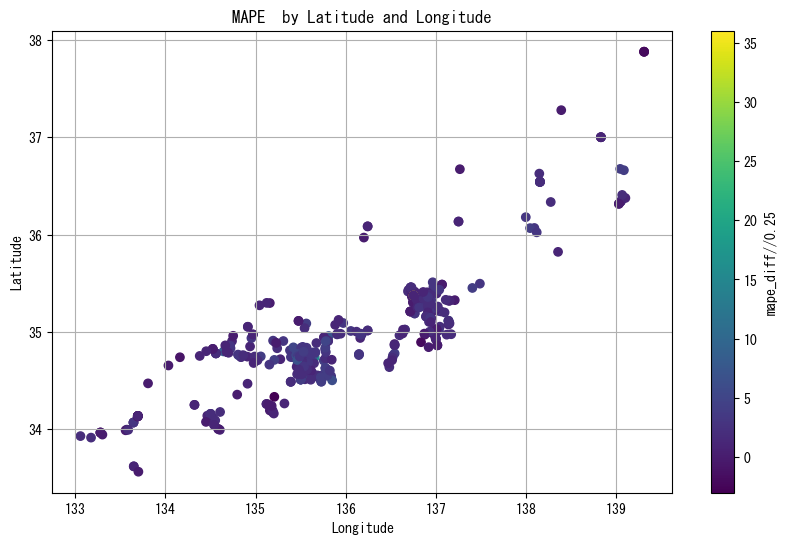

In [248]:
import pandas as pd
import matplotlib.pyplot as plt

col = "mape_diff//0.25"
df = mape_all

# データのプロット
plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df[col], cmap='viridis')
plt.colorbar(label=col)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE  by Latitude and Longitude')
plt.grid(True)
plt.show()


In [244]:
mape_all

,id,mape_flo,mape_flo_lgbm,mape_not_flo_lgbm,mape_flo_lgbm//1,id_lat,id_lng,observed_max2,mape_flo//1,mape_diff,mape_diff//1,mape_diff//0.5
0,5.640000e+02,6.904307,6.893072,8.158208,6.0,36.67271,137.26581,5165.6,6.0,0.011236,0.0,0.0
1,1.000001e+07,10.472319,6.426823,8.503090,6.0,34.73957,135.65565,5044.8,10.0,4.045495,4.0,8.0
2,1.010000e+09,6.167342,5.380385,6.637307,5.0,34.91010,135.19389,2869.4,6.0,0.786957,0.0,1.0
3,1.010000e+09,6.483243,5.410645,7.199070,5.0,34.74816,135.05721,2453.0,6.0,1.072598,1.0,2.0
4,1.010000e+09,6.193481,5.701761,7.055221,5.0,34.85029,134.93844,3405.0,6.0,0.491720,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
385,6.910000e+09,6.326878,5.914713,7.234752,5.0,35.02229,136.63515,15868.8,6.0,0.412164,0.0,0.0
386,6.910000e+09,5.996077,5.768937,7.052270,5.0,36.31680,139.02919,16049.8,5.0,0.227140,0.0,0.0
387,6.910000e+09,6.072263,5.952638,7.306398,5.0,36.31680,139.02919,10723.2,6.0,0.119625,0.0,0.0
388,6.910001e+09,6.393586,5.907887,7.626292,5.0,35.10132,136.94275,16904.0,6.0,0.485700,0.0,0.0


In [246]:
mape_all[["mape_flo","mape_flo_lgbm"]].describe()

,mape_flo,mape_flo_lgbm
count,390.000000,390.000000
mean,6.407653,5.738470
std,0.921309,0.527715
min,3.272302,3.448429
25%,5.919042,5.414649
50%,6.272015,5.644710
75%,6.760485,5.970592
max,16.191929,8.165847


In [ ]:
mape_all["mape_flo//0.25"] = mape_all["mape_flo"]//0.25

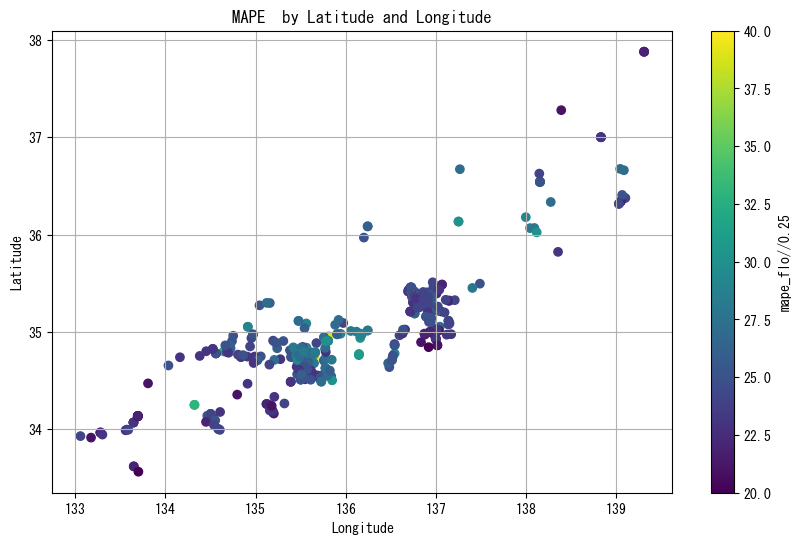

In [255]:
df = mape_all

col = "mape_flo//0.25"
df = mape_all
vmin = 20
vmax = 40 

# データのプロット
plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df[col], cmap='viridis',vmin=vmin, vmax=vmax)
plt.colorbar(label=col)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE  by Latitude and Longitude')
plt.grid(True)
plt.show()


In [252]:
mape_all

,id,mape_flo,mape_flo_lgbm,mape_not_flo_lgbm,mape_flo_lgbm//1,id_lat,id_lng,observed_max2,mape_flo//1,mape_diff,mape_diff//1,mape_diff//0.5,mape_diff//0.25,mape_flo//0.25
0,5.640000e+02,6.904307,6.893072,8.158208,6.0,36.67271,137.26581,5165.6,6.0,0.011236,0.0,0.0,0.0,27.0
1,1.000001e+07,10.472319,6.426823,8.503090,6.0,34.73957,135.65565,5044.8,10.0,4.045495,4.0,8.0,16.0,41.0
2,1.010000e+09,6.167342,5.380385,6.637307,5.0,34.91010,135.19389,2869.4,6.0,0.786957,0.0,1.0,3.0,24.0
3,1.010000e+09,6.483243,5.410645,7.199070,5.0,34.74816,135.05721,2453.0,6.0,1.072598,1.0,2.0,4.0,25.0
4,1.010000e+09,6.193481,5.701761,7.055221,5.0,34.85029,134.93844,3405.0,6.0,0.491720,0.0,0.0,1.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,6.910000e+09,6.326878,5.914713,7.234752,5.0,35.02229,136.63515,15868.8,6.0,0.412164,0.0,0.0,1.0,25.0
386,6.910000e+09,5.996077,5.768937,7.052270,5.0,36.31680,139.02919,16049.8,5.0,0.227140,0.0,0.0,0.0,23.0
387,6.910000e+09,6.072263,5.952638,7.306398,5.0,36.31680,139.02919,10723.2,6.0,0.119625,0.0,0.0,0.0,24.0
388,6.910001e+09,6.393586,5.907887,7.626292,5.0,35.10132,136.94275,16904.0,6.0,0.485700,0.0,0.0,1.0,25.0


# オプティカルフローの誤差要因

In [296]:
mape_all.corr()["mape_flo"].sort_values(ascending=False,key=abs)

mape_flo             1.000000
mape_flo//0.25       0.996729
mape_flo//1          0.953149
mape_diff            0.826513
mape_diff//0.25      0.824026
mape_diff//0.5       0.807560
mape_diff//1         0.783750
mape_flo_lgbm        0.705994
mape_not_flo_lgbm    0.666871
mape_flo_lgbm//1     0.663639
observed_max2       -0.107948
id_lat               0.048543
id_lng               0.027492
id                  -0.022378
Name: mape_flo, dtype: float64

In [311]:
df,unique_id = utils.load_data2()
df['prev_30m_generation/observed_max2'] = df['prev_30m_generation'] / df["observed_max2"]
df["(nv2-prev_30m_generation/observed_max2).abs()"] = (df["nv2"] - df['prev_30m_generation/observed_max2']).abs()

df = df[df.month.isin([5,6,7])]

fluctuation = dict()
for id,group in df.groupby("id"):
    fluctuation[id] = group["(nv2-prev_30m_generation/observed_max2).abs()"].mean()

fluctuation  = pd.DataFrame(list(fluctuation.items()),columns=["id","fluctuation"])

In [332]:
mape_all = mape_all.merge(fluctuation,on="id",how="left")

In [335]:
mape_all.corr()["mape_flo"].sort_values(ascending=False,key=abs)

mape_flo             1.000000
mape_flo//0.25       0.996729
mape_flo//1          0.953149
mape_diff            0.826513
mape_diff//0.25      0.824026
mape_diff//0.5       0.807560
mape_diff//1         0.783750
mape_flo_lgbm        0.705994
mape_not_flo_lgbm    0.666871
mape_flo_lgbm//1     0.663639
fluctuation          0.414815
observed_max2       -0.107948
id_lat               0.048543
id_lng               0.027492
id                  -0.022378
Name: mape_flo, dtype: float64

In [336]:
mape_all

,id,mape_flo,mape_flo_lgbm,mape_not_flo_lgbm,mape_flo_lgbm//1,id_lat,id_lng,observed_max2,mape_flo//1,mape_diff,mape_diff//1,mape_diff//0.5,mape_diff//0.25,mape_flo//0.25,fluctuation
0,5.640000e+02,6.904307,6.893072,8.158208,6.0,36.67271,137.26581,5165.6,6.0,0.011236,0.0,0.0,0.0,27.0,0.088354
1,1.000001e+07,10.472319,6.426823,8.503090,6.0,34.73957,135.65565,5044.8,10.0,4.045495,4.0,8.0,16.0,41.0,0.076885
2,1.010000e+09,6.167342,5.380385,6.637307,5.0,34.91010,135.19389,2869.4,6.0,0.786957,0.0,1.0,3.0,24.0,0.075097
3,1.010000e+09,6.483243,5.410645,7.199070,5.0,34.74816,135.05721,2453.0,6.0,1.072598,1.0,2.0,4.0,25.0,0.079134
4,1.010000e+09,6.193481,5.701761,7.055221,5.0,34.85029,134.93844,3405.0,6.0,0.491720,0.0,0.0,1.0,24.0,0.085558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,6.910000e+09,6.326878,5.914713,7.234752,5.0,35.02229,136.63515,15868.8,6.0,0.412164,0.0,0.0,1.0,25.0,0.084332
386,6.910000e+09,5.996077,5.768937,7.052270,5.0,36.31680,139.02919,16049.8,5.0,0.227140,0.0,0.0,0.0,23.0,0.081457
387,6.910000e+09,6.072263,5.952638,7.306398,5.0,36.31680,139.02919,10723.2,6.0,0.119625,0.0,0.0,0.0,24.0,0.082653
388,6.910001e+09,6.393586,5.907887,7.626292,5.0,35.10132,136.94275,16904.0,6.0,0.485700,0.0,0.0,1.0,25.0,0.089619


In [345]:
for _ , group in mape_all.groupby("mape_flo//1"):
    print(_,group.corr()["mape_flo"]["fluctuation"])
    #break

3.0 nan
4.0 nan
5.0 0.4670367267536083
6.0 0.3697641588190183
7.0 0.003194267920138502
8.0 0.20484114992790423
9.0 0.4554637598523741
10.0 nan
16.0 nan


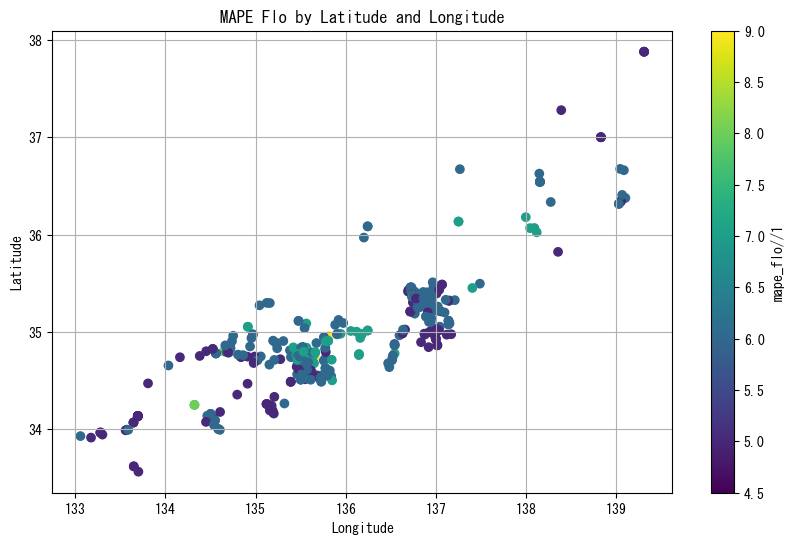

In [354]:
df = mape_all

col = 'mape_flo//1'
vmin =  4.5
vmax =  9

plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df[col], cmap='viridis',vmin=vmin,vmax=vmax)
plt.colorbar(label=col)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE Flo by Latitude and Longitude')
plt.grid(True)
plt.show()


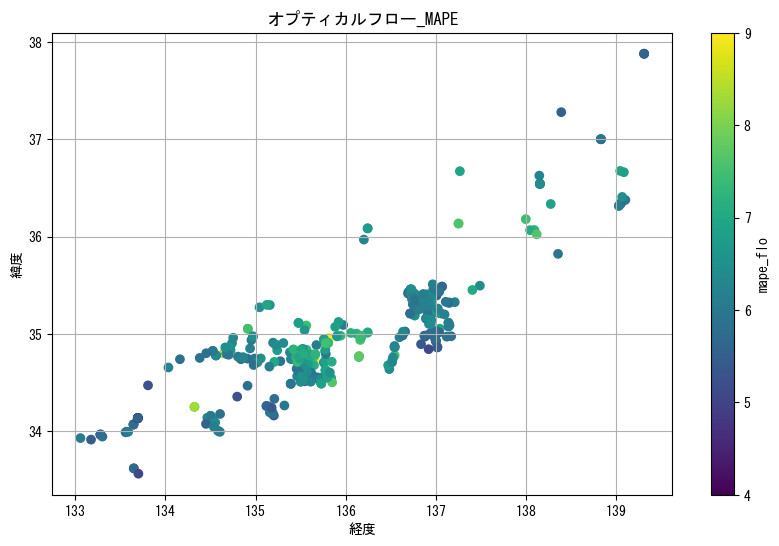

In [363]:
df = mape_all

col = 'mape_flo'
vmin =  4
vmax =  9

fig = plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df[col], cmap='viridis',vmin=vmin,vmax=vmax)
plt.colorbar(label=col)
plt.xlabel('経度')
plt.ylabel('緯度')
plt.title('オプティカルフロー_MAPE')
plt.grid(True)
plt.show()
fig.savefig(r'C:\Users\Yosui\Desktop\hiroki\lab\ゼミ\進捗報告\230525\flo_lat_lng.png') 


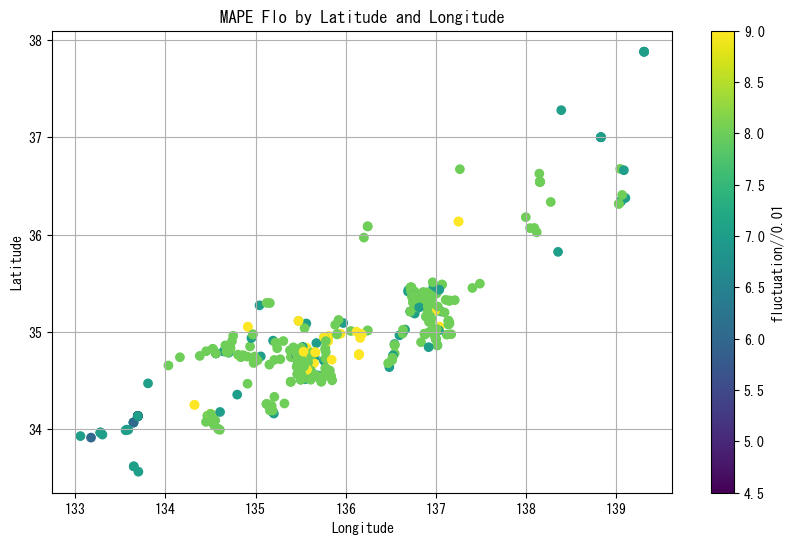

In [359]:
df = mape_all

col = "fluctuation"
vmin =  4.5
vmax =  9

plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df[col], cmap='viridis',vmin=vmin,vmax=vmax)
plt.colorbar(label=col)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MAPE Flo by Latitude and Longitude')
plt.grid(True)
plt.show()


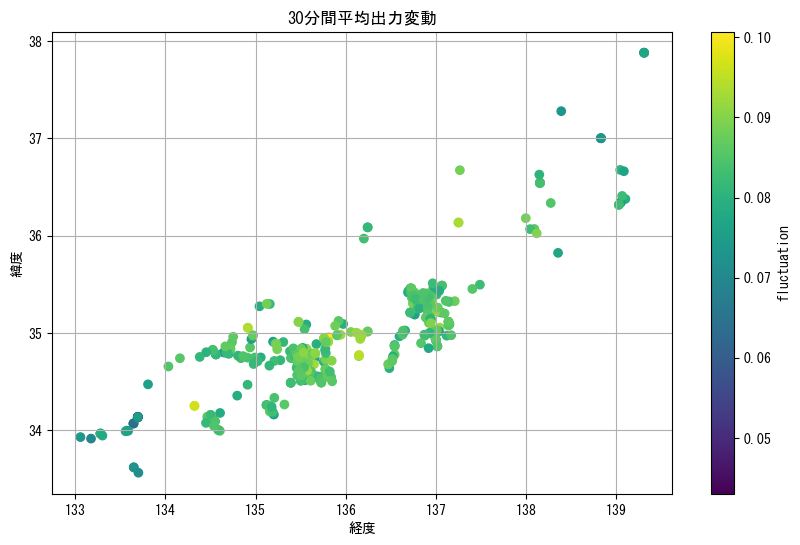

In [364]:
df = mape_all

col = "fluctuation"


fig = plt.figure(figsize=(10, 6))
plt.scatter(df['id_lng'], df['id_lat'], c=df[col], cmap='viridis')
plt.colorbar(label=col)
plt.xlabel('経度')
plt.ylabel('緯度')
plt.title('30分間平均出力変動')
plt.grid(True)
plt.show()
fig.savefig(r'C:\Users\Yosui\Desktop\hiroki\lab\ゼミ\進捗報告\230525\fluc_lat_lng.png') 